In [1]:
import os,sys
import h5py
import numpy as np
import corner as DFM

In [2]:
from sklearn import decomposition

In [3]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/Users/chahah/data/arcoiris/provabgs_cnf/'

ftheta = os.path.join(dat_dir, 'train.set0.thetas.npy')
thetas = np.load(ftheta)

flssps = os.path.join(dat_dir, 'train.set0.miles_mist.lssp.lssps.npy')
lssps_fid = np.load(flssps)

fwaves = os.path.join(dat_dir, 'train.set0.miles_mist.lssp.waves.npy')
waves_fid = np.load(fwaves)

In [5]:
waves = waves_fid[0]

In [6]:
wlim = (waves > 1.5e3) & (waves < 7e4)

In [7]:
lssps_m2 = np.load(os.path.join(dat_dir, 'train.set0.miles_pdva.lssp.lssps.npy'))
lssps_m3 = np.load(os.path.join(dat_dir, 'train.set0.miles_prsc.lssp.lssps.npy'))
lssps_m4 = np.load(os.path.join(dat_dir, 'train.set0.miles_bsti.lssp.lssps.npy'))

In [8]:
lssp_ratios_m2 = lssps_m2/lssps_fid 
lssp_ratios_m3 = lssps_m3/lssps_fid
lssp_ratios_m4 = lssps_m4/lssps_fid

In [9]:
X = np.vstack([lssp_ratios_m2[:,wlim], lssp_ratios_m3[:,wlim], lssp_ratios_m4[:,wlim]]).T

(1500.0, 20000.0)

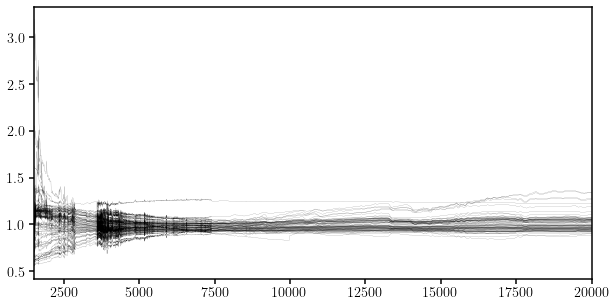

In [10]:
fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
for i in np.arange(X.shape[1])[::1000]: 
    sub.plot(waves[wlim], X[:,i], c='k', lw=0.1)
sub.set_xlim(1.5e3, 2e4)

In [11]:
X_q = np.quantile(X.T, [0.025, 0.16, 0.5, 0.84, 0.975], axis=0)

(0.0, 2.0)

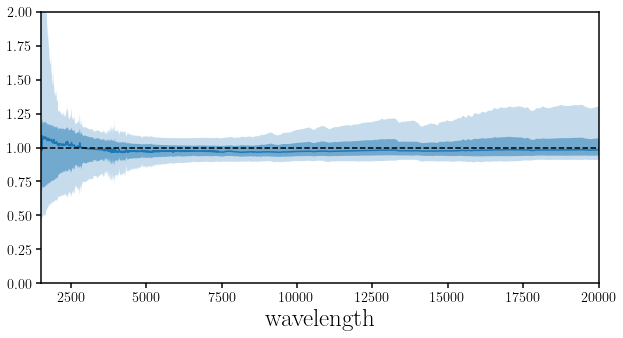

In [12]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.fill_between(waves[wlim], X_q[0], X_q[-1], facecolor='C0', edgecolor='none', alpha=0.25)
sub.fill_between(waves[wlim], X_q[1], X_q[-2], facecolor='C0', edgecolor='none', alpha=0.5)
sub.plot(waves[wlim], X_q[2], c='C0')
sub.plot([1e3, 5e4], [1., 1.], c='k', ls='--')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1.5e3, 2e4)
sub.set_ylim(0., 2.)

In [13]:
lnX_q = np.quantile(np.log(X.T), [0.025, 0.16, 0.5, 0.84, 0.975], axis=0)

(-1.0, 1.0)

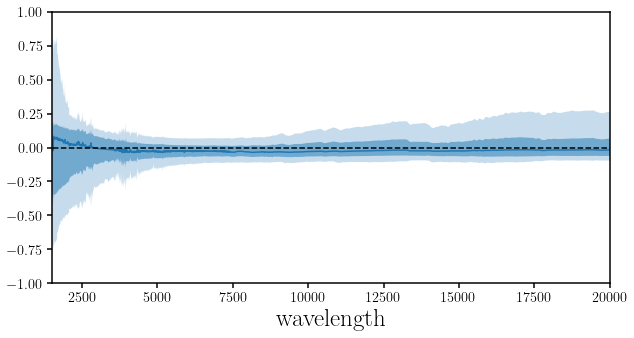

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.fill_between(waves[wlim], lnX_q[0], lnX_q[-1], facecolor='C0', edgecolor='none', alpha=0.25)
sub.fill_between(waves[wlim], lnX_q[1], lnX_q[-2], facecolor='C0', edgecolor='none', alpha=0.5)
sub.plot(waves[wlim], lnX_q[2], c='C0')
sub.plot([1e3, 5e4], [0., 0.], c='k', ls='--')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1.5e3, 2e4)
sub.set_ylim(-1., 1.)

In [15]:
lnpca = decomposition.PCA(n_components=10)
lnpca.fit(np.log(X.T))

PCA(n_components=10)

In [16]:
np.cumsum(lnpca.explained_variance_ratio_)

array([0.61210363, 0.80993084, 0.90303194, 0.95931949, 0.97518495,
       0.98317554, 0.98909378, 0.99181211, 0.99374034, 0.99465308])

(1500.0, 20000.0)

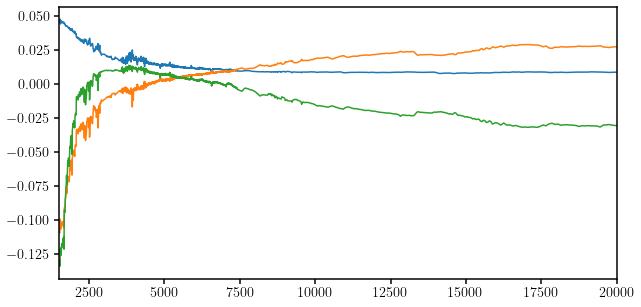

In [17]:
fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
for i in range(3): 
    sub.plot(waves[wlim], lnpca.components_[i])
sub.set_xlim(1.5e3, 2e4)

In [41]:
# save PCA components
np.save('sed_isochrone_unc.wave.npy', waves[wlim])
np.save('sed_isochrone_unc.pca.npy', lnpca.components_[:3,:])

In [18]:
lnX_pca = lnpca.transform(np.log(X.T))

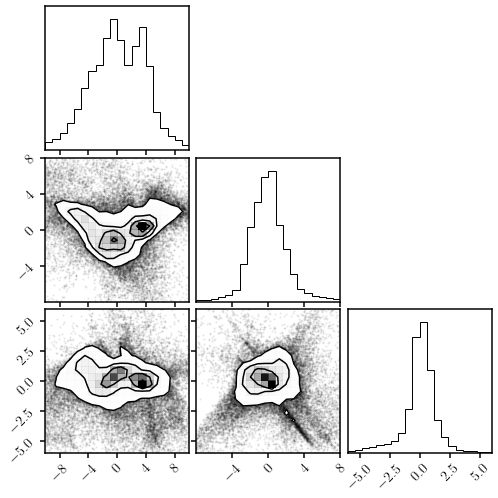

In [19]:
fig = DFM.corner(lnX_pca[:,:3], range=[(-10, 10), (-8, 8), (-6, 6)], hist1d_kwargs={'density': True})

In [20]:
mu_lnpca = np.mean(lnX_pca[:,:3], axis=0)
cov_lnpca = np.cov(lnX_pca[:,:3].T)

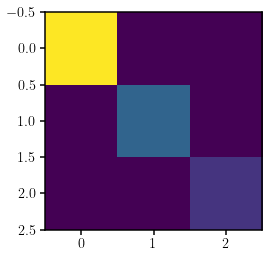

In [21]:
plt.imshow(cov_lnpca)

In [29]:
cov_lnpca * np.eye(3)

array([[18.66727496, -0.        , -0.        ],
       [-0.        ,  6.03312034, -0.        ],
       [-0.        , -0.        ,  2.83929654]])

In [22]:
print(np.sqrt(np.diag(cov_lnpca)))

[4.32056419 2.4562411  1.68502123]


In [30]:
pca_coeff_samples = np.random.multivariate_normal(mu_lnpca, cov_lnpca * np.eye(3), size=10000)

In [31]:
lnX_samples = np.sum([lnpca.components_[i][:,None] * pca_coeff_samples[:,i][None,:] for i in range(3)], axis=0)

In [32]:
lnX_samples_q = np.quantile(lnX_samples, [0.025, 0.16, 0.5, 0.84, 0.975], axis=1)

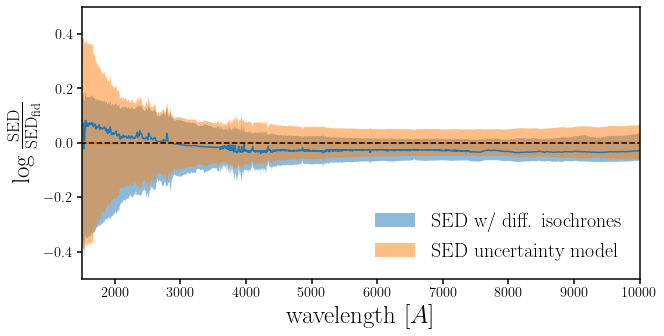

In [33]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

#sub.fill_between(waves[wlim], lnX_q[0], lnX_q[-1], facecolor='C0', edgecolor='none', alpha=0.25)
sub.fill_between(waves[wlim], lnX_q[1], lnX_q[-2], facecolor='C0', edgecolor='none', alpha=0.5, 
                 label=r'SED w/ diff. isochrones')
sub.plot(waves[wlim], lnX_q[2], c='C0')

#sub.fill_between(waves[wlim], lnX_samples_q[0], lnX_samples_q[-1], facecolor='C1', edgecolor='none', alpha=0.25)
sub.fill_between(waves[wlim], lnX_samples_q[1], lnX_samples_q[-2], facecolor='C1', edgecolor='none', alpha=0.5, 
                label=r'SED uncertainty model')
sub.plot(waves[wlim], lnX_samples_q[2], c='C1')

sub.legend(loc='lower right', fontsize=20)
sub.plot([1e3, 5e4], [0., 0.], c='k', ls='--')
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(1.5e3, 1e4)
sub.set_ylabel(r'$\log \frac{\rm SED}{\rm SED_{\rm fid}}$', fontsize=25)
sub.set_ylim(-0.5, 0.5)
fig.savefig('../doc/paper/figs/sed_ratio.pdf', bbox_inches='tight')

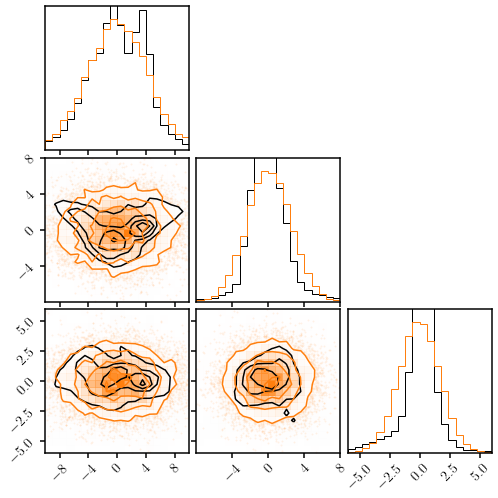

In [34]:
fig = DFM.corner(lnX_pca[:,:3], range=[(-10, 10), (-8, 8), (-6, 6)], hist_kwargs={'density': True}, 
                 plot_datapoints=False)
_ = DFM.corner(pca_coeff_samples, range=[(-10, 10), (-8, 8), (-6, 6)], hist_kwargs={'density': True}, fig=fig, color='C1')